In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [33]:
# Calculate the date 1 year ago from the last data point in 
#the database
last = session.query(func.max(measurement.date))[0][0]
first = dt.datetime.strptime(last, '%Y-%m-%d') - dt.timedelta(days=365) 

# Perform a query to retrieve the date and precipitation 
#scores
prcpQuery = (session.query(measurement.date, measurement.prcp)
            .filter(measurement.date >= first)
            .order_by(measurement.date).all())

In [34]:
# Save the query results as a Pandas DataFrame and set the 
#index to the date column
prcpData = pd.DataFrame(prcpQuery)
prcpData = prcpData.set_index('date')

# Sort the dataframe by date
prcpData = prcpData.sort_index()

prcpData.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


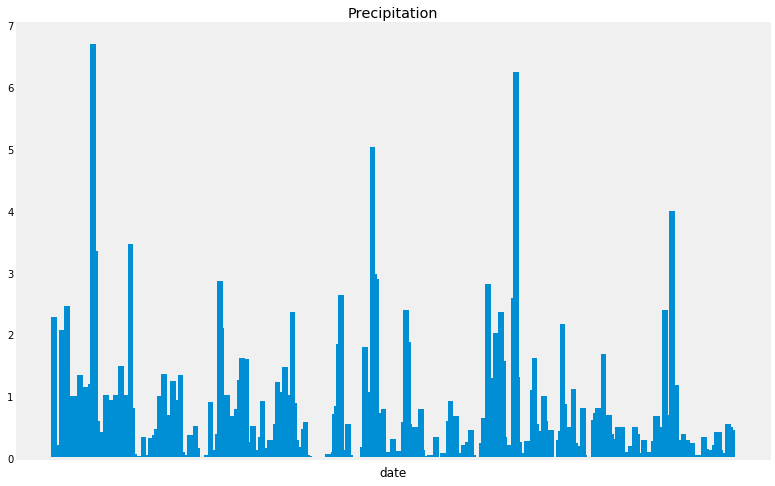

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,8))
plt.bar(prcpData.index,prcpData['prcp'], width=3)
plt.xticks(prcpData.index, "")
plt.title('Precipitation')
plt.xlabel('date')
plt.grid()

In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpData.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [37]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(station).count()
stations

9

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStations = (session.query(measurement.station, func.count(measurement.station))
                .group_by(measurement.station)
                .order_by(func.count(measurement.station).desc()).all())
activeStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded
mostActive = activeStations[0][0]

lowest = (session.query(func.min(measurement.tobs))
        .filter(measurement.station == mostActive).all())[0][0]
print(f'Lowest: {lowest}')

# ...highest temperature recorded, and 
highest = (session.query(func.max(measurement.tobs))
        .filter(measurement.station == mostActive).all())[0][0]
print(f'Highest: {highest}')

#...average temperature of the most active station?
average = (session.query(func.avg(measurement.tobs))
        .filter(measurement.station == mostActive).all())[0][0]
print(f'Average: {round(average,1)}')

Lowest: 54.0
Highest: 85.0
Average: 71.7


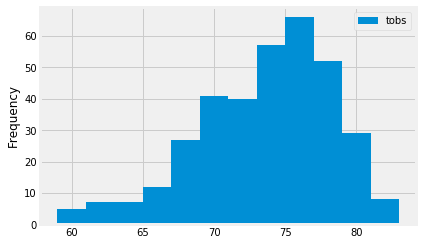

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot 
#the results as a histogram

activeQuery = (session.query(measurement.tobs)
            .filter(measurement.date >= first)
            .filter(measurement.station == mostActive).all())

activeData = pd.DataFrame(activeQuery)

activeData.plot.hist(bins=12)

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [77]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start = '2016-03-10'
end = '2016-03-20'

start_prev_yr = dt.datetime.strptime(start, '%Y-%m-%d') - dt.timedelta(days=365) 
end_prev_yr = dt.datetime.strptime(end, '%Y-%m-%d') - dt.timedelta(days=365)

prev_yr = calc_temps(start_prev_yr, end_prev_yr)
prev_yr

[(56.0, 67.4920634920635, 80.0)]

Text(0, 0.5, 'Temp(F)')

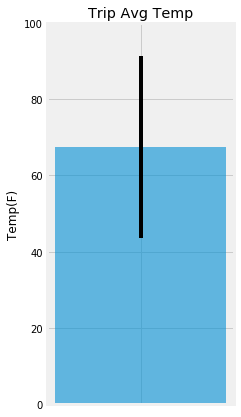

In [78]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


avgT = prev_yr[0][1]
maxT = prev_yr[0][2]
minT = prev_yr[0][0]

yerr = maxT - minT

fig, ax = plt.subplots(figsize=(3,7))

ax.bar("", avgT,  yerr=yerr, alpha = 0.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)

plt.ylabel('Temp(F)')

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the 
#previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude,
#longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
